# IMDB Edits Analysis

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from evaluate import load
from matplotlib.ticker import PercentFormatter
from pylev import levenshtein as lev_dist

from utils.gpt2_functions import *

## Main Code

### Helping Functions

In [2]:
def plot_distribution(scores, x_title, nbins=None, xticks_interval=0.2):
    plt.figure(figsize=(12, 6))
    plt.hist(scores, bins=nbins, weights=np.ones(len(scores)) / len(scores))
    plt.xticks(np.arange(0, max(scores), xticks_interval))
    plt.title(x_title + ' Distribution')
    plt.xlabel(x_title)
    plt.ylabel('Edits Percentage')

    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.show()

In [3]:
def get_statistics(scores, score_name):
    print(f'Max {score_name.lower()}: {max(scores)}')
    print(f'Min {score_name.lower()}: {min(scores)}')
    print(f'Mean {score_name.lower()}: {np.mean(scores)}')

### Load Data

In [4]:
counter_sents = pd.read_csv('../Edits/imdb/gnn_imdb_edge_filter_edits.csv').values.tolist()
original_sents = pd.read_csv('../Data/imdb_reviews.csv')[['Source_Sentences']].values.tolist()

assert len(counter_sents) == len(original_sents)

### Fluency Analysis

In [ ]:
# first plot fluency for each pair of sentences
cuda = not torch.cuda.is_available()
model, tokenizer = model_init('t5-base', cuda=cuda)
fluency_scores = []
for i in tqdm(range(len(counter_sents))):
    fl_score = sent_scoring(model, tokenizer, counter_sents[i][0], cuda=cuda)[0] / sent_scoring(model, tokenizer,                 original_sents[i][0], cuda=cuda)[0]

    fluency_scores.append(fl_score)

In [6]:
get_statistics(fluency_scores, 'Fluency Score')

Max fluency score: 3.8149702988134706
Min fluency score: 0.6202773687819234
Mean fluency score: 1.034011622783155


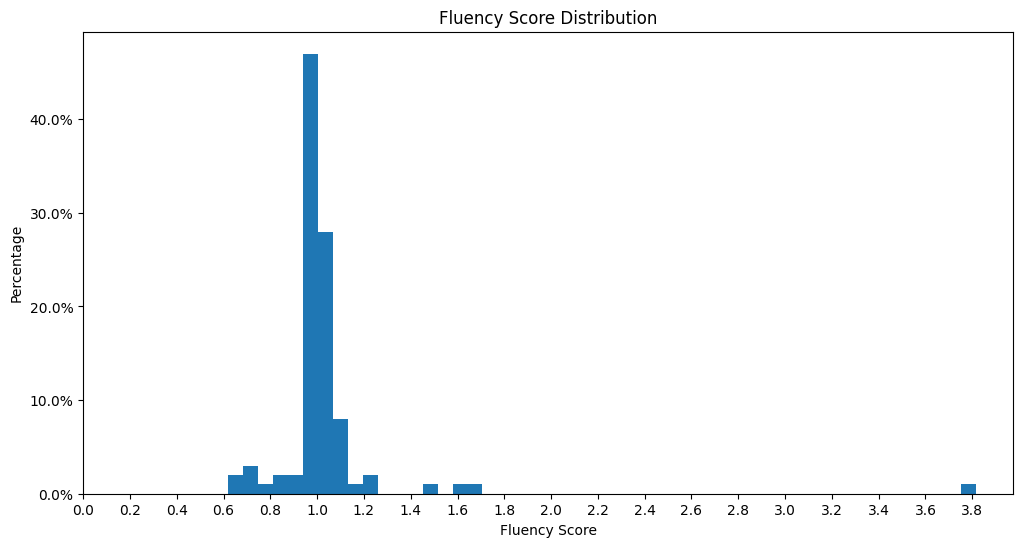

In [7]:
plot_distribution(fluency_scores, 'Fluency Score', nbins=50)

In [8]:
# finding outliers
for i in range(len(fluency_scores)):
    if fluency_scores[i] > 1:
        print(f'Original: \n{original_sents[i][0]}')
        print(f'Counter: \n{counter_sents[i][0]}')
        print(f'Fluency Score: {fluency_scores[i]}')
        print()

Original: 
When I see a movie, I usually seek entertainment. But of course if I know what genre the move is, then I will seek what it is meant to do. For example, if it is a deep film, I expect the film to rile thoughts up in my cranium and make me ponder what it is saying. But Who's That Girl? is not a deep film. But it is entertaining, nonetheless. It's a campy sort of film that's a joy to watch. There's barely a boring moment in the film and there are plenty of humorous parts. I've watched it when I was younger. The cast is always entertaining as usual. I had a small crush on Griffin Dunne even though he wasn't the typical male heartthrob at the time. Haviland Morris also stars. And late Austrian actress Bibi Besch is here too! Overall, a delight!
Counter: 
when i see a movie, i usually seek entertainment. but of course if i know what genre the move is, then i will seek what it is meant to do. for example, if it is a deep film, i expect the film to rile thoughts up in my cranium and

### Bertscore Analysis

In [9]:
bertscore = load("bertscore")
os = [x[0] for x in original_sents]
cs = [x[0] for x in counter_sents]

bert_scores = bertscore.compute(predictions=cs, references=os, model_type="distilbert-base-uncased")['f1']

In [10]:
get_statistics(bert_scores, 'Bertscore')

Max bertscore: 0.9989335536956787
Min bertscore: 0.9747743010520935
Mean bertscore: 0.988529868721962


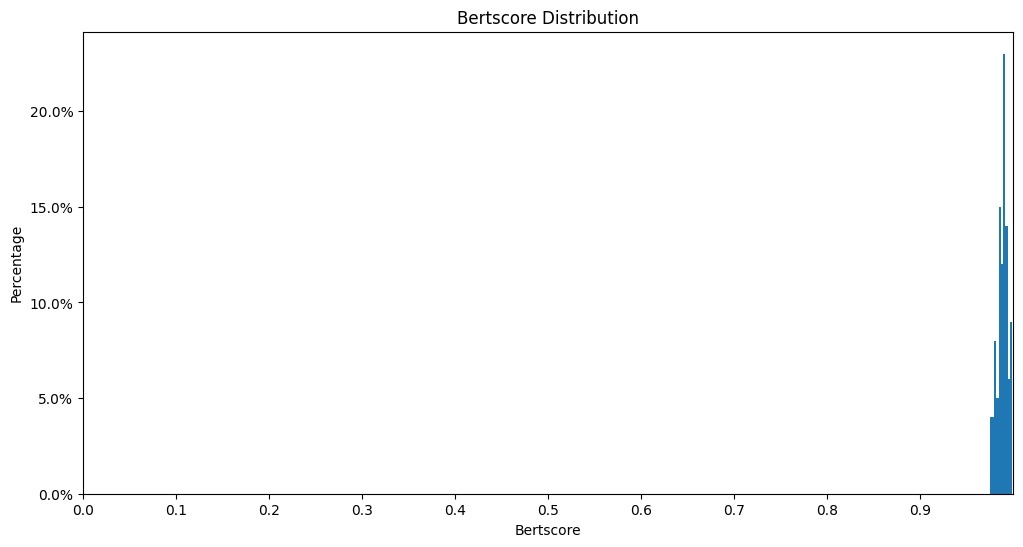

In [11]:
plot_distribution(bert_scores, 'Bertscore', nbins=10, xticks_interval=0.1)

### Closeness (Levenshtein Distance) Analysis

In [12]:
lev_scores = []
for i in tqdm(range(len(counter_sents))):
    num_words = len(original_sents[i][0].split())
    lev_scores.append(lev_dist(original_sents[i][0].lower(), counter_sents[i][0]) / num_words)

100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


In [13]:
get_statistics(lev_scores, 'Levenshtein Distance')

Max levenshtein distance: 0.4782608695652174
Min levenshtein distance: 0.026578073089700997
Mean levenshtein distance: 0.19083951682357853


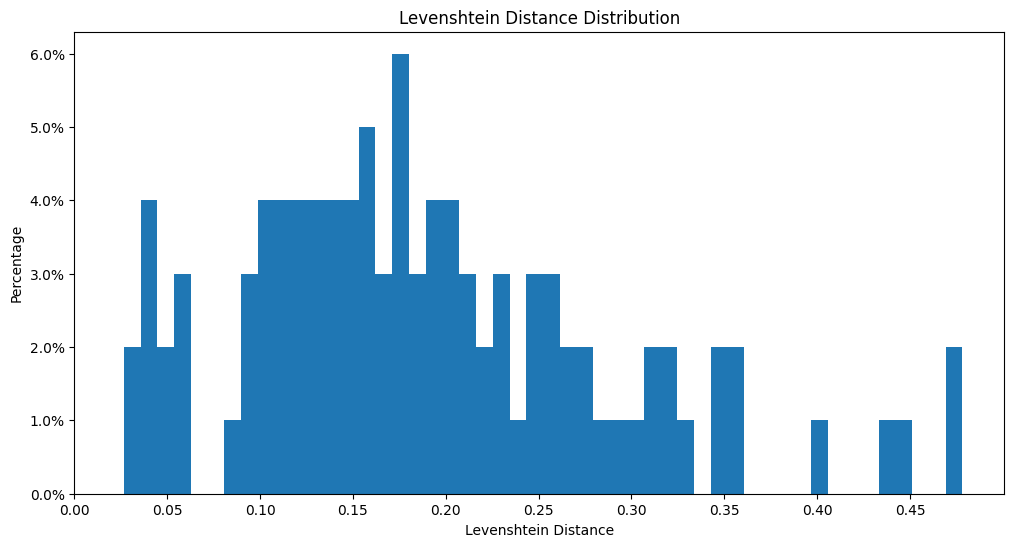

In [16]:
plot_distribution(lev_scores, 'Levenshtein Distance', nbins=50, xticks_interval=0.05)

In [17]:
# finding outliers
for i in range(len(lev_scores)):
    if lev_scores[i] > 0.35:
        print(f'Original: \n{original_sents[i][0]}')
        print(f'Counter: \n{counter_sents[i][0]}')
        print(f'Levenshtein Distance: {lev_scores[i]}')
        print()

Original: 
I thought this was a really well written film. I've heard of Radio the person before this movie was even created and I can't begin to describe how good Cuba Gooding Jr was in it. It will make the women cry, everyone laugh, and most everyone will leave smiling.
Counter: 
i thought this was a really well written film. i've heard of radio the person before this movie was even created and i can't begin to describe how good cuba gooding jr was in it. it will grovelling the women cry, everyone laugh, and situation everyone reason leave smiling.
Levenshtein Distance: 0.46938775510204084

Original: 
I'm normally not a Drama/Feel good movie kind of guy, but once I saw the trailer for "Radio", I couldn't resist. Not only is this a great film, but it also has grreat acting. Cuba Gooding Jr. did an excellent job portraying James Robert Kennedy, a.k.a. "RAdio." Ed Harris also did a fantastic job as Coach Jones. I was pleasantly surprised to see some comedy in it as well. So for a great s